### Building a Neural Network from scratch + Comparison to Keras
while we can build neural networks (NN) with only a few lines of code using high level Python packages such as Keras/tensorflow, building one from scratch helps making sure we understand everything. I will try to write efficient, vectorised code instead of the much slower for/while loops. The datasets could be anything, so we start with the famous MNIST set of handwritten digits and build a classifier. The result will then be compared to a Keras model.

Start by importing some libraries:

In [1]:
import numpy as np                                
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
from skimage import io
import keras as k
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


Import the data

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
(n_pix,m_train,m_test)=(len(mnist.train.images[0]),len(mnist.train.images),len(mnist.test.images))
print('n_pix='+str(n_pix)+', '+ 'm_train='+str(m_train)+', '+ 'm_test='+str(m_test))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
n_pix=784, m_train=55000, m_test=10000


The data is already separated into m_train train images and m_test test images with corresponding labels. 
The images are in greyscale (values 0-1) and are given as a one-dimensional vector with length n_pix (=number of pixels).

In [3]:
(n_pix,m_train,m_test)=(len(mnist.train.images[0]),len(mnist.train.images),len(mnist.test.images))
print('n_pix='+str(n_pix)+', '+ 'm_train='+str(m_train)+', '+ 'm_test='+str(m_test))

n_pix=784, m_train=55000, m_test=10000


We can show the images by reshaping them into (28x28) arrays and use the io package to display them

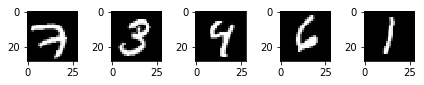

In [4]:
piclist=[pic.reshape((28,28)) for pic in mnist.train.images[0:5]]
io.imshow_collection(piclist)
io.show()

Let's check the true values.

In [5]:
answerlist=[np.where(label==1)[0].item() for label in mnist.train.labels[0:5]]
answerlist

[7, 3, 4, 6, 1]

### Neural Network geometry

The geometry of a simple NN consists of an input layer (in our case the 784 pixel values), followed by a number of hidden layers and finally an output layer (with in our case $K=10$ neurons representing the 10 possible digits). Following the deep learning course by Andrew Ng on coursera, the total number of layers (not counting the input) is called $L$, with $s_l$ neurons in layer $l=0...L$, and $s_L=K$ neurons in the output layer.

The neurons have values called activations $a^{[l]}$, starting with the input values $a^{[0]}$, the pixel values of our image. To calculate the activation vector $a^{[l]}$ of the neurons in layer $l$, we first multiply the activation vector of the previous layer $a^{[l-1]}$ with the corresponding weight matrix $W^{[l]}$ and add a bias vector $b^{[l]}$, to produce $z^{(l)}= W^{[l]} a^{[l-1]}+b^{[l]}$. The matrices $W^{[l]}$ and the bias vectors $b^{[l]}$ represent the parameters that will be learned through training of the network.

The resulting vector $z^{[l]}$ is fed into a nonlinear activation function to give the activation of the neurons of the next layer, $a^{[l]}=g(z^{[l]})$. Historically, the sigmoid function $\sigma(z)=\frac{1}{1+exp(-z)}$ was used, or alternatively $tanh(z)$, but recently the computationally easier RELU function $r(z)=max(0,z)$ is the preferred choice for all but the output layer. Here often the softmax function $s(z)_j=\frac{exp(z_j)}{\sum_{k=1}^K exp(z_k)}$ is used, which is conveniently normalised ($\sum s(z)_j=1$) and will be interpreted as probability that the input image belongs to a class.

Instead of looping through all $m$ training examples $x^{(i)}$, I will vectorise the process to be more efficient: The data points $x^{(i)}$ will be stored as columns in a matrix $A^{[0]}$, and the corresponding $z$-values will be the columns of the matrix $Z^{[l]}$, with $Z^{[l]}=W^{[l]} A^{[l-1]}+b^{[l]}$.


In [6]:
#some functions we need and their gradients:

def sigmoid(z):
    z=np.clip( z, -500, 500 )                       #restrict z to (-500,500) to avoid overflow
    return 1.0/(1.0+np.exp(-z))

def relu(z):
    return np.maximum(0,z)

def softmax(z):
    z=np.clip( z, -500, 500 )                       #restrict z to (-500,500) to avoid overflow
    ex=np.exp(z)                                            
    return ex / np.sum(ex, axis=0,keepdims=True)    #column wise sum (collapse column vector to number)

def grad_sigmoid(z):
    sig=sigmoid(z)
    return sig*(1-sig)

def grad_relu(z):
    z=z>0                       #the gradient at zero is not defined, but it's ok here to set it to zero
    return z.astype(int)

def grad_softmax(z):
    grad=np.multiply(softmax(z),np.ones(z.shape)-softmax(z))
    return grad 

### Initialisation and feed forward
The process described above is called feed forward, and in practice we initialise the weigth matrices of a network randomly and can feed forward to a first guess (interpreting the activations of the last layer as a measure for likelihoood of the corresponding outcome). We will use either sigmoid or relu as activation in all hidden layers and sigmoid or softmax in the output layer. The list "sizes" will contain the numbers of neurons in each layer, $(s_0, ..., s_L)$. For example, sizes=[784,40,10] corresponds to a single hidden layer of 40 neurons between the input layer (784 neurons) and output layer (10 neurons). 

### Cost function + regularisation
Once the activation of the final (=output) layer is calculated, we can compare it to the true label and define a loss or cost function, describing how far off we are. The aim will be to minimise this cost function. The total cost over the training (or test) set is the average of the cost terms $J$ of each data point $(x^{(i)},y^{(i)})$, $J_{tot}=\frac{1}{m}\sum_m J$.

There are different choices for the cost, for example the cross entropy $J=-\sum_k y_k\,log(a_k)+ (1-y_k)\,log((1-a_k))$, where $a$ is the activation of the output layer and $y$ is the true label vector, with a one marking the correct answer.

To prevent overfitting, we regularise the cost by adding a term $\frac{\lambda}{2 m}\sum_l ||W^{[l]}||^2$, which sums up the squared weights of all connections in the network, effectively penalising the algorithm for using large weights. The parameter $\lambda$ should be chosen carefully.

### Training the network: Back propagation and gradient descent
We now minimise the cost by calculating the gradient of the cost with respect to the weights and biases. For this, we change the weights and biases proportional to a learning rate $\alpha$ in the direction of the partial gradients of the cost function: $W^{[l]}\rightarrow W^{[l]}- \alpha\frac{\partial J}{ \partial W^{[l]}}$ and $b^{[l]}\rightarrow b^{[l]}- \alpha \frac{\partial J}{ \partial b^{[l]}}$. The process can be compared with trying to get to the top of a mountain by always taking a step (with step size $\alpha$) in the steepest direction. If $\alpha$ is too large we might step too far, but if $\alpha$ is too small, it will take forever and we might get stuck on a small hill.

So how do we get the gradients? Just like we found the final activation layer by propagating forward through the layers, we now propagate backwards to get all derivatives: We start with the last layer, $\frac{\partial J}{ \partial W^{[L]}}=\frac{\partial J}{ \partial z^{[L]}}\frac{\partial z^{[L]}}{ \partial W^{[L]}}$ with $\frac{\partial z^{[L]}}{ \partial W^{[L]}}=a^{[L-1]}$ and the "error" of layer $L$, defined as $\delta^{[L]}:=\frac{\partial J}{ \partial z^{[L]}}$. All partial derivatives with respect to a vector are to be understood elementwise (e.g. $\delta_j^{[L]}:=\frac{\partial J}{ \partial z_j^{[L]}}$), and so is the multiplication between the vectors.

Next, we calculate the errors from $\delta^{[L]}=\frac{\partial J}{ \partial a^{[L]}}\frac{\partial a^{[L]}}{ \partial z^{[L]}}$ with $\frac{\partial J}{ \partial a_k}=\frac{\partial }{ \partial a_k} \left( -\sum_{k'} y_{k'}\,log(a_{k'})+ (1-y_{k'})\,log((1-a_{k'})) \right)=-\frac{y_k}{a_k}+\frac{1-y_k}{1-a_k}=\frac{a_k-y_k}{a_k(1-a_k)}$ for cross entropy and $\frac{\partial a^{[L]}}{\partial z^{[L]}}=\frac{\partial}{ \partial z^{[L]}}g(z^{[L]})=g'(z^{[L]})$. If $g=softmax$, we get $g'(z)=softmax(z)\,(1-softmax(z))=a \,(1-a)$ since $a=g(z)$, and similarly if $g=sigmoid$, $g'(z)=sigmoid(z)\,(1-sigmoid(z))=a \,(1-a)$. In both cases the error reduces to $\delta^{[L]}=a^{[L]}-y$.

Finally, the error of layer ($l-1$) can be calculated from the error of layer $l$ via $\delta^{[l-1]}=(W^{[l]})^T   \delta^{[l]}\, g'(z^{[l-1]})$, where $W^T$ is the transposed weight matrix. For the biases, we simply have $\frac{\partial J}{ \partial b^{[l]}}=\delta^{[l]}$.

Another implementation detail is the Mini-batch method. In backpropagation, we calculate the gradient of the cost function with respect to $b$ or $W$ by averaging over all training examples. This can take long, so instead a common method is to select a random subset called "mini-batch" of $n<m$ training examples and take the average gradient of those. As a result, the algorithm will be changing the weights and biases in a sometimes less optimum way, which might in rare cases even increase the cost, but eacch step will be done much faster. Typical step size could be $n=10-100$, compared to $m=55000$ in our case.

Let's build our class:

In [7]:
class myNetwork:
    
    def __init__(self, sizes, activation, activation_final):  # store pameters of the network
        self.sizes=sizes
        self.biases=[np.zeros((s, 1)) for s in sizes[1:]]
        self.weights=[np.sqrt(2/sizes[0])*np.random.randn(s2, s1) for s1, s2 in zip(sizes[:-1], sizes[1:])]     #gaussian weights
        self.activation=activation
        self.activation_final=activation_final
    
    def gradient_descent(self, A, Y, A_test, Y_test, epochs, bsize, alpha, lmbda):
    
        m=len(A.T)
        A_test_norm=((A_test-np.mean(A))/np.std(A)) #normalise test and training data (both in the same way):
        A=(A-np.mean(A))/np.std(A)
    
        A_in=A                                  #store for evaluation
        Y_in=Y                                  
    
        acc_train_list=[]
        acc_test_list=[]
          
        for e in range(epochs):                           #loop through forward- and backprop
        
            [Ashuffled,Yshuffled]=self.shuffle(A,Y)            #Ashuffled (784 x m), Yshuffled (10 x m)
            nb=int(np.floor(m/bsize))                     # number of minibatches per epoch
        
            for b in range(nb):
             
                A=Ashuffled[:,(b*bsize):((b+1)*bsize)]    #(784 x bsize)
                Y=Yshuffled[:,(b*bsize):((b+1)*bsize)]    #(10 x bsize)
            
                #feed forward to get activations:
                [Zlist,Alist]=self.feedforward(A)
            
                #backprop:      
                [dWlist,dblist]=self.backprop(Alist,Zlist,Y, bsize)
                      
                #update weights and biases (with L2 regularisation):                        
                [self.weights,self.biases]=self.update(dWlist,dblist,alpha,lmbda)
                    
            acc_train=self.accuracy(A_in,Y_in)
            acc_test=self.accuracy(A_test_norm,Y_test)
            acc_train_list.append(acc_train)
            acc_test_list.append(acc_test)
        
        return [self.weights, self.biases,acc_train_list,acc_test_list]
    
    def feedforward(self, A):
        Alist=[A]
        Zlist=[]
    
        for k in range(len(self.weights)-1):                  # relu or sigmoid as activation for hidden layers
            Z=np.dot(self.weights[k], A)+self.biases[k]            #add same vector b to each column of matrix ("broadcasting")
            A = self.activation(Z)
            Zlist.append(Z)
            Alist.append(A)
        
        Z=np.dot(self.weights[-1], A)+self.biases[-1]
        A = self.activation_final(Z)                         #softmax or sigmoid as activation for final layer
        Alist.append(A)
        Zlist.append(Z)

        return [Zlist,Alist]                            #return the activations and z's
    
    def backprop(self, Alist,Zlist,Y, bsize):        #single backpropagation
    
        if str(self.activation)==str(sigmoid):       # allow two different activation functions for the hidden layers
            grad_activation=grad_sigmoid
        elif str(self.activation)==str(relu):
            grad_activation=grad_relu
        else: print("check activation")  

        L=len(self.sizes)-1                                  #don't count the input layer
        dWlist=[]                                         # list to save weights errors in each mini-batch run
        dblist=[] 
    
        #first backprop step in output layer (sigmoid or softmax):
        dZ=Alist[-1]-Y                                                 # dZ2:(10 x bsize), A2:(10 x bsize)
        dW=1/bsize*np.dot(dZ, Alist[-2].T)                             #dW2:(10 x s1), A1:(s1 x bsize)
        db=1/bsize*np.sum(dZ,axis=1,keepdims=True)                      #db2:(10 x 1)
        dWlist.append(dW)
        dblist.append(db)     
                      
        #step backwards through hidden layers (sigmoid or relu)
        for j in range(L-1):
            xz=np.dot(self.weights[-(j+1)].T,dZ)                        #xz:(s1 x bsize)                      
            dZ=np.multiply(xz, grad_activation(Zlist[-(j+2)]))          #dZ1:(s1 x bsize)
            dW=1/bsize*np.dot(dZ, Alist[-(j+3)].T)                      #dW1:(s1 x 784)
            db=1/bsize*np.sum(dZ,axis=1,keepdims=True)                                
            dWlist.append(dW)
            dblist.append(db)
    
        return [dWlist,dblist]
    
    def update(self,dWlist,dblist,alpha,lmbda):     # updates weights and biases with L2 regularisation
        for j in range(len(dWlist)):
            self.weights[-(j+1)]=(1-alpha*lmbda)*self.weights[-(j+1)]-alpha*dWlist[j]
        for k in range(len(dblist)):
            self.biases[-(k+1)]=self.biases[-(k+1)]-alpha*dblist[k]
        return [self.weights, self.biases]
    
    def shuffle(self,A,Y):                          #shuffles columns of images and labels
        shuffled=np.vstack((A,Y))                     
        np.random.shuffle(shuffled.T)                 
        return [shuffled[0:-10,:],shuffled[-10:,:]]
    
    def accuracy(self, A, Y):  #check prediction accuracy on test (or training) data
        A_final=self.feedforward(A)[1][-1]
        predict_list=A_final.argmax(axis=0)    
        true_list=Y.argmax(axis=0)
        return sum(predict_list==true_list)/len(predict_list)
    

### Testing the network: Hyper parameters, Bias and Variance

Now that the algorithm is set up, we can train the model parameters (weights and biases) for different sets of hyper parameters (choice of activation function, number of neurons and hidden layers, learning rate, regularisation). I will mostly work with one hidden layer, and start without regularisation. 

In order to help finding the right parameters, it helps to know about the high bias/ high variance problem. In a high bias situation, the model doesn't have enough degrees of freedom to make good fits to the data (imagine fitting a linear function to quadraticly looking data). Here, additional data will not help, but instead the model should be made more complex (e.g. more neuron, more layers). If instead we have high variance, the model fits perfecctly to the training data but fails to generalise well to also classify the test data. This "over-fitting" can be avoided by adding more data or other techniques such as regularisation (e.g. increase $\lambda$) or drop out.

### Learning rate decay

Another trick in stochastic gradient descent is to slowly reduce the learning rate or to use an update that depends on the mean or variance of the past gradients (e.g. see "Adam" or "RMSprop"). This idea can be imagined as as marble rolling down the cost-surface, which would still keep rolling in a locally flat region due to the momentum (or speed) collected in the past steeper regions.

In [8]:
A=mnist.train.images.T                        # we want the m training examples stored in columns, not rows
Y=mnist.train.labels.T
A_test=mnist.test.images.T
Y_test=mnist.test.labels.T

In [37]:
acc_train=[]
acc_test=[]
runs=5           # run multiple times to see if random initialisation changes accuracy

for i in range(runs):
    net00=myNetwork([784,400,10], relu, softmax)  #initialise network
    [Wlist, blist,acc_train_list,acc_test_list]=net00.gradient_descent(A, Y, A_test,Y_test, 1,100,0.3,0)
    acc_train.append(acc_train_list[-1])
    acc_test.append(acc_test_list[-1])
    
print("training accuracy=" + str(np.mean(acc_train)) + "+-" + str(np.std(acc_train)) )
print("test accuracy=" + str(np.mean(acc_test))  + "+-" + str(np.std(acc_test)))

training accuracy=0.973432727273+-0.00219777197473
test accuracy=0.96668+-0.00221033934046


### Summary + Comparison to Keras
The home-made neural network works and classifies the test images with an accuracy of about $96.7$ percent (1 hidden layer with 400 neurons, $\alpha=0.3, \,\lambda=0$ (didn't help), $bsize=100$, using relu for hidden layers and softmax on the output layer). The training on all 55000 images takes 8 seconds for one epoch (on my 3 year old laptop). The code is about 110 lines long, compared to about 10 lines in Keras (see below). The Keras model is faster by (only) a factor 2 and gives test accuracies of only 91 percent after 1 epoch, probably due to a slower (and decaying) learning rate. However, it learns better over additional epochs, reaching 96.5 percent after 10 epochs and then rising further to 97.5 over 30 epochs.

In [25]:
model = Sequential()
model.add(Dense(units=300, activation='relu', input_dim=784))
model.add(Dense(units=10, activation='softmax'))

In [26]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [29]:
#training for 1 epoch, then rebuild model
acc_test_keras=[]
A_norm=((A-np.mean(A))/np.std(A)).T
A_test_norm=((A_test-np.mean(A))/np.std(A)).T
for i in range(10):
    model = Sequential()
    model.add(Dense(units=400, activation='relu', input_dim=784))
    model.add(Dense(units=10, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
    model.fit(A_norm, mnist.train.labels, epochs=1, batch_size=100)
    loss_and_metrics = model.evaluate(A_test_norm, mnist.test.labels, batch_size=100)
    acc_test_keras.append(loss_and_metrics[1])
print("test accuracy=" + str(np.mean(acc_test_keras))  + "+-" + str(np.std(acc_test_keras)))

Epoch 1/1
10000/10000 [==============================] - 1s 70us/step
Epoch 1/1
10000/10000 [==============================] - 1s 58us/step
Epoch 1/1
10000/10000 [==============================] - 1s 55us/step
Epoch 1/1
10000/10000 [==============================] - 1s 56us/step
Epoch 1/1
10000/10000 [==============================] - 1s 56us/step
Epoch 1/1
10000/10000 [==============================] - 1s 63us/step
Epoch 1/1
10000/10000 [==============================] - 1s 59us/step
Epoch 1/1
10000/10000 [==============================] - 1s 67us/step
Epoch 1/1
10000/10000 [==============================] - 1s 63us/step
Epoch 1/1
10000/10000 [==============================] - 1s 70us/step
test accuracy=0.915550003052+-0.0017704515308
